# Cross Validation

In [1]:
import sys

sys.path.append("..")
sys.path.append("../../inputs")

In [2]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    stream=sys.stdout,
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [3]:
from omegaconf import OmegaConf

c = OmegaConf.load("../config/main.yaml")

c.settings.debug = False
c.wandb.enabled = False
c.wandb.group = "LB"
c.wandb.dir = "../../cache/"
c.settings.dirs.working = ".."
c.settings.dirs.input = "../../inputs/"

pretraind_dir = "../../datasets/trainings"

In [4]:
pretrained = f"""



- dir: {pretraind_dir}/2022-03-18_20-53-27/fold0/ 
  model: lightgbm
  n_class: 1
  count_oof: 1

- dir: {pretraind_dir}/2022-04-09_21-25-31/fold0/ 
  model: xgboost
  n_class: 1
  count_oof: 1


- dir: {pretraind_dir}/2022-03-18_10-49-32/fold0/
  model: tabnet
  n_class: 1
  count_oof: 1



- dir: {pretraind_dir}/2022-03-25_10-03-26/fold0/
  model: ump_1_tf
  model_input: 300
  n_class: 1
  count_oof: 1
- dir: {pretraind_dir}/2022-03-25_10-03-31/fold1/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-25_10-03-36/fold2/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-25_10-04-06/fold3/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-25_10-04-11/fold4/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-25_10-04-17/fold5/
  model: ump_1_tf
  model_input: 300
  n_class: 1




- dir: {pretraind_dir}/2022-03-18_16-17-11/fold1/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
  count_oof: 1
- dir: {pretraind_dir}/2022-03-18_16-17-17/fold2/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-18_16-18-16/fold4/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-18_16-18-21/fold5/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-18_16-17-06/fold0/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-18_16-18-10/fold3/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1



- dir: {pretraind_dir}/2022-03-17_20-47-04/fold1/
  model: ump_lstm
  model_input: 300
  n_class: 10
  count_oof: 1
- dir: {pretraind_dir}/2022-03-17_20-47-09/fold2/
  model: ump_lstm
  model_input: 300
  n_class: 10
- dir: {pretraind_dir}/2022-03-17_20-47-41/fold4/
  model: ump_lstm
  model_input: 300
  n_class: 10
- dir: {pretraind_dir}/2022-03-17_20-47-47/fold5/
  model: ump_lstm
  model_input: 300
  n_class: 10
- dir: {pretraind_dir}/2022-03-17_20-46-59/fold0/
  model: ump_lstm
  model_input: 300
  n_class: 10
- dir: {pretraind_dir}/2022-03-17_20-47-36/fold3/
  model: ump_lstm
  model_input: 300
  n_class: 10



"""

_pretrained = f"""


- dir: {pretraind_dir}/2022-03-29_10-09-02/fold0/ 
  model: lightgbm
  n_class: 1
  count_oof: 3


- dir: {pretraind_dir}/2022-03-29_10-21-27/fold0/ 
  model: tabnet
  n_class: 1
  count_oof: 3


- dir: {pretraind_dir}/2022-04-02_07-08-39/fold0/
  model: ump_1_tf
  model_input: 300
  n_class: 1
  count_oof: 3
- dir: {pretraind_dir}/2022-04-02_07-08-44/fold1/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_07-08-50/fold2/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_07-08-55/fold3/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_07-09-00/fold4/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_19-42-00/fold5/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_19-42-05/fold6/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_19-42-11/fold7/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_19-42-16/fold8/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-02_19-42-21/fold9/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-03_07-11-36/fold10/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-03_07-11-41/fold11/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-03_07-11-47/fold12/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-03_07-11-52/fold13/
  model: ump_1_tf
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-03_07-11-57/fold14/
  model: ump_1_tf
  model_input: 300
  n_class: 1


- dir: {pretraind_dir}/2022-03-31_21-19-11/fold0/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
  count_oof: 3
- dir: {pretraind_dir}/2022-03-31_21-19-16/fold1/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-31_21-19-22/fold2/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-31_21-19-27/fold3/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-03-31_21-19-32/fold4/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_09-33-13/fold5/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_09-33-18/fold6/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_09-33-23/fold7/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_09-33-28/fold8/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_09-33-33/fold9/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_20-16-37/fold10/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_20-16-41/fold11/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_20-16-47/fold12/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_20-16-52/fold13/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1
- dir: {pretraind_dir}/2022-04-01_20-16-57/fold14/
  model: ump_1dcnn_small
  model_input: 300
  n_class: 1




- dir: {pretraind_dir}/2022-03-29_15-56-29/fold0/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
  count_oof: 3
- dir: {pretraind_dir}/2022-03-29_15-56-34/fold1/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-29_15-56-39/fold2/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-29_15-56-45/fold3/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-29_15-56-50/fold4/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-30_14-03-07/fold5/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-30_14-03-12/fold6/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-30_14-03-18/fold7/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-30_14-03-23/fold8/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-30_14-03-28/fold9/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-31_06-54-10/fold10/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-31_06-54-15/fold11/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-31_06-54-21/fold12/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-31_06-54-26/fold13/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]
- dir: {pretraind_dir}/2022-03-31_06-54-31/fold14/
  model: ump_lstm
  model_input: 300
  n_class: 10
  feature_set: ["f001", "f902"]






"""

c.params.pretrained = OmegaConf.create(pretrained)

In [5]:
log.info(OmegaConf.to_yaml(c))

2022-04-09 21:39:15,452 [INFO] [3244290467] defaults:
- _self_
hydra:
  run:
    dir: ../outputs/${now:%Y-%m-%d_%H-%M-%S}
  job_logging:
    formatters:
      simple:
        format: '%(asctime)s [%(levelname)s][%(module)s] %(message)s'
wandb:
  enabled: true
  entity: imokuri
  project: ump
  dir: ../../cache/
  group: LB
settings:
  print_freq: 100
  gpus: '6'
  dirs:
    working: ..
    input: ../../inputs/
    input_minimal: ${hydra:runtime.cwd}/../datasets/inputs/
    feature: ${settings.dirs.input}features/
    preprocess: ${settings.dirs.input}preprocess/
  inputs:
  - train.csv
  debug: false
  n_debug_data: 100000
  amp: true
  multi_gpu: true
  training_method: nn
params:
  seed: 17440
  n_class: 1
  preprocess: []
  pca_n_components: 50
  n_fold: 5
  skip_training: false
  epoch: 10
  es_patience: 0
  batch_size: 640
  gradient_acc_step: 1
  max_grad_norm: 1000
  fold: combinational_purged
  group_name: investment_id
  time_name: time_id
  label_name: target
  use_feature: t

In [6]:
import os

import pandas as pd
import seaborn as sns
import src.utils as utils
from src.get_score import record_result
from tqdm.notebook import tqdm

In [7]:
run = utils.setup_wandb(c)

2022-04-09 21:39:17,290 [ERROR] [jupyter] Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2022-04-09 21:39:21,396 [INFO] [utils] WandB initialized. name: royal-snow-540, id: 1xrbpmsb


In [8]:
train = pd.read_feather("../../inputs/train.f")
train = train.loc[:, ["row_id", "time_id", "target"]]
train.set_index("row_id", inplace=True)

In [9]:
preds_col = []
count_oof = 0

# 各 OOF の結果を読み取り
for n, training in tqdm(enumerate(c.params.pretrained), total=len(c.params.pretrained)):
    preds_col.append(f"preds{n}")
    oof_df = pd.read_feather(os.path.join(training.dir.rsplit("/", 2)[0], "oof_df.f")).set_index("row_id")

    train[f"preds{n}"] = oof_df["preds"].groupby("row_id").sum()
    try:
        count_oof += training.count_oof
    except Exception:
        pass

# 各行の OOF の結果の数をカウントする
# train["count_oof"] = len(c.params.pretrained) - train.isnull().sum(axis=1)

# OOF の結果がない行を 0 埋め
train.fillna(0, inplace=True)

# OOF の結果をマージ
train["preds"] = 0
for col in preds_col:
    train["preds"] += train[col]

# 推論結果がないものは除外
train = train[train["preds"] != 0.0]

# 複数 OOF を加算している場合は、OOFの数で割る
# train["preds"] = train["preds"] / train["count_oof"]
train["preds"] = train["preds"] / count_oof

  0%|          | 0/21 [00:00<?, ?it/s]

In [10]:
train

,time_id,target,preds0,preds1,preds2,preds3,preds4,preds5,preds6,preds7,...,preds12,preds13,preds14,preds15,preds16,preds17,preds18,preds19,preds20,preds
row_id,,,,,,,,,,,,,,,,,,,,,
0_1,0,-0.300875,0.021285,0.077232,0.012218,0.050720,0.0,0.0,0.0,0.0,...,0.000000,0.069763,0.0,0.0,0.0,0.0,0.000000,0.129272,0.0,0.060082
0_2,0,-0.231040,-0.031725,-0.075876,-0.054585,-0.011719,0.0,0.0,0.0,0.0,...,0.000000,-0.018707,0.0,0.0,0.0,0.0,0.000000,0.015518,0.0,-0.029516
0_6,0,0.568807,0.046931,0.037660,-0.022041,0.074158,0.0,0.0,0.0,0.0,...,0.000000,0.072998,0.0,0.0,0.0,0.0,0.000000,0.086792,0.0,0.049416
0_7,0,-1.064780,-0.030124,-0.022600,-0.145309,-0.052856,0.0,0.0,0.0,0.0,...,0.000000,-0.096069,0.0,0.0,0.0,0.0,0.000000,-0.105652,0.0,-0.075435
0_8,0,-0.531940,-0.018096,-0.129730,-0.050417,0.075684,0.0,0.0,0.0,0.0,...,0.000000,0.038300,0.0,0.0,0.0,0.0,0.000000,0.093689,0.0,0.001572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219_3768,1219,0.033600,-0.093386,-0.091932,-0.027354,0.000000,0.0,0.0,0.0,0.0,...,-0.028015,0.000000,0.0,0.0,0.0,0.0,-0.123535,0.000000,0.0,-0.067601
1219_3769,1219,-0.223264,-0.085313,-0.089989,-0.029044,0.000000,0.0,0.0,0.0,0.0,...,-0.061646,0.000000,0.0,0.0,0.0,0.0,-0.137329,0.000000,0.0,-0.076604
1219_3770,1219,-0.559415,0.051074,0.003174,0.013071,0.000000,0.0,0.0,0.0,0.0,...,0.046112,0.000000,0.0,0.0,0.0,0.0,0.066040,0.000000,0.0,0.046758


In [11]:
# train["count_oof"].value_counts()
count_oof

6

In [12]:
# train = train[train["count_oof"] != 3]
# train["count_oof"].value_counts()

In [13]:
record_result(c, train, c.params.n_fold)

2022-04-09 21:40:14,757 [INFO] [get_score] Score: 0.14679


0.14679113768905377

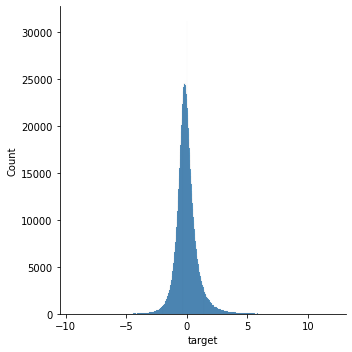

In [14]:
sns.displot(train["target"])

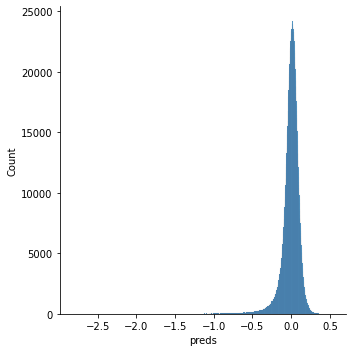

In [15]:
sns.displot(train["preds"])

In [16]:
train_min = train[(train["target"] > -3.5) & (train["target"] < 3.5)]

In [17]:
if not c.wandb.enabled:
    record_result(c, train_min, c.params.n_fold)